# Comparaison d’´echantillons et tests multiples -- Code R


## 0 - Généralités sur nos Données 

## 0 - a) ratWeight

In [1]:
## On importe les données
ratWeight <- read.csv(file="ratWeight_sujet3.csv", header=TRUE, sep=",")

In [2]:
head(ratWeight)

id,week,weight,regime,gender,dosage
B38602,1,236.1,Control,Male,11%
B38602,2,282.6,Control,Male,11%
B38602,3,336.0,Control,Male,11%
B38602,4,376.8,Control,Male,11%
B38602,5,403.9,Control,Male,11%
B38602,6,414.3,Control,Male,11%


In [3]:
## Nombre de lignes au total
nrow(ratWeight)

[1] 2235

In [4]:
## On sélectionne la 14ème semaine
ratW14<-ratWeight[ratWeight$week==14,]
nrow(ratW14)

[1] 158

In [5]:
X_new=ratW14[ratW14$regime == 'GMO',] ## Groupe sous OGM
Y_new=ratW14[ratW14$regime == 'Control',] ## Groupe témoin

In [6]:
X=X_new$weight
Y=Y_new$weight

In [7]:
length(X)

[1] 79

In [8]:
length(Y)

[1] 79

## 0 - b) leucemie

## 2 - Variance inconnue 

## 3 - Test non paramétrique 

![title](Consignes-Exo3.png)

## 3 - a)

In [9]:
get_Ranked_R1<-function(x,y){
## Fonction dans laquelle on met deux vecteurs x et y et on a la somme des rangs du premier dans le vecteur total (R1 de l'énoncé) 
    m=length(x)+length(y)
    df_1<-data.frame(data=x,type=1)
    df_2<-data.frame(data=y,type=0)
    df<-rbind(df_1,df_2)
    or<-df[order(df$data),]
    return(sum((or$type==1)*(1:m)))
}    

Le $R_1$ de nos données est :

In [10]:
get_Ranked_R1(X,Y)

[1] 6311

In [11]:
get_Quantile_empirique<-function(x,alpha){
## Fonction pour obternir le quantil empirique de niveau alpha de l'échantillon x
    rank=floor(length(x)*alpha)+1
    return(x[order(x)][rank])
}

In [12]:
estim_quantil_R1<-function(n1,n2,alpha,m){
## Estimation du quantil de niveau alpha de R1 
## n1 le nombre d'échantillons dans le premier groupe, n2 pour le deuxième groupe
## m le nombre de simulation de R1 que l'on souhaite faire pour approximer le quantil
    x<-c()
    for (i in 1:m) {
        y1<-runif(n1,0,1)
        y2<-runif(n2,0,1)
        x<-c(x,get_Ranked_R1(y1,y2))
    }
    return(get_Quantile_empirique(x,alpha))
}

In [13]:
evolE<- function(x){              
##evolution estimateurde de Monte Carlo
  return(cumsum(x)/(1:length(x)))
}

evolIC <- function(x, delta, level) {  
##evolution interval de confiance de niveau estimateurde de Monte Carlo
  n <- length(x)
  s2 <- (cumsum(x^2) - (1:n) * (delta)^2)/(0:(n - 1)) 
  IC <- qnorm(0.5 * (level + 1)) * sqrt(s2/(1:n))     ##calcul de q* racindeVar 
  return(data.frame(var = s2, born_inf_IC = delta - IC,born_sup_IC = delta + IC))
}


In [14]:
MC <- function(y,lev,constante) {   ##Methode de monte carlo classique
  a<-evolE(y)        ## on recupere l'evolution de l'estimateur
  b<-evolIC(y,a,lev) ## on recupere l'evolution de l'intervalle de confiance
  n<-length(y)
  par(mfrow=c(1,1))
  plot(1:n, a, type = "l", lwd = 2, col = "darkorange1",main = "Evolution de l'estimation de Monte Carlo", ylim = c(-0.2,min(c(max(b$born_sup_IC[-1])+0.3),10)), xlab = "n",ylab="y")
  lines(2:n, b$born_inf_IC[-1], col = "deepskyblue3", lwd = 2)
  lines(2:n, b$born_sup_IC[-1], col = "deepskyblue3", lwd = 2)
  lines(1:n, rep(constante,n), col = "deeppink", lwd = 2)
  legend("topright", c("Intervalle de confiance", "estimateur de Monte Carlo",constante), lwd = c(3, 1),
         col = c("deepskyblue3", "darkorange1","deeppink"), inset = 0.05, bg = "gray95",
         box.lty = 0)
  return(data.frame(valeur_estimateur_MC=a[n],b[n,]))
}

In [15]:
tester_quantil_empirique<-function(n1,n2,mq,mmc,alpha){
    
    q_emp<-estim_quantil_R1(n1,n2,alpha,mq)
    print(paste0("Le quantil empirique est : " , q_emp))
    x<-c()
    for (i in 1:mmc){
        y1<-runif(n1,0,1)
        y2<-runif(n2,0,1)
        x<-c(x,1*(get_Ranked_R1(y1,y2)<=q_emp))
    }
       
    MC(x,0.5,alpha)
    
}

[1] "Le quantil empirique est : 5744"


,valeur_estimateur_MC,var,born_inf_IC,born_sup_IC
1000,0.027,0.0262973,0.02354116,0.03045884


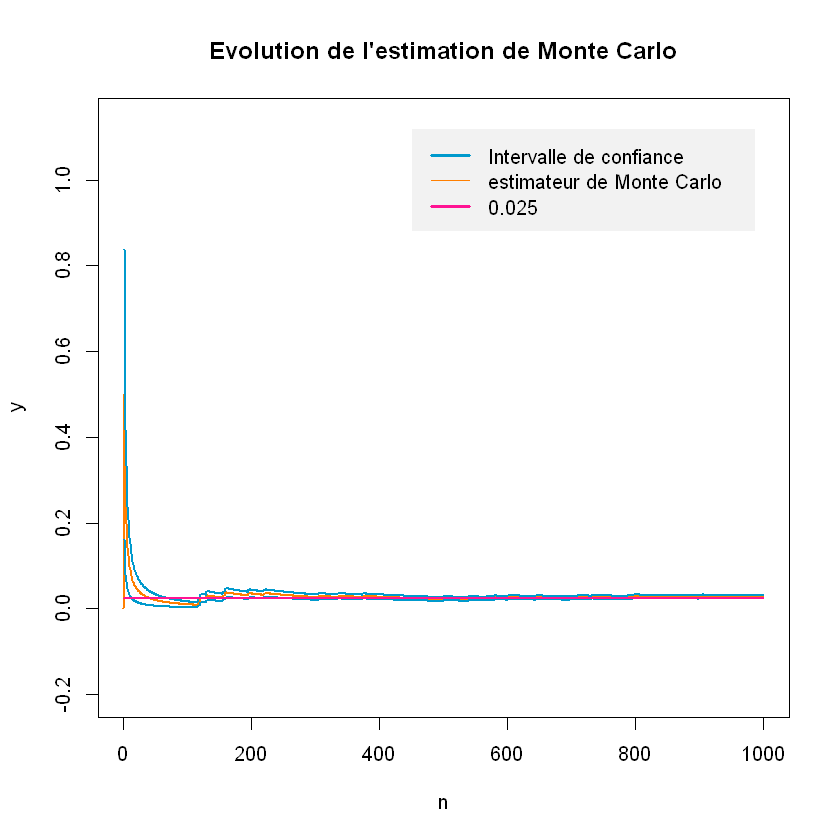

In [16]:
set.seed(25) ## Pour pouvoir reproduire les résultats 

## Les arguments sont : 
## (Nombres dans groupe 1, nombre dans groupe 2, nombre pour quantil empirique, nombre pour MC, niveau quantil)

tester_quantil_empirique(79,79,1000,1000,0.025)  


[1] "Le quantil empirique est : 6837"


,valeur_estimateur_MC,var,born_inf_IC,born_sup_IC
1000,0.974,0.02534935,0.9706041,0.9773959


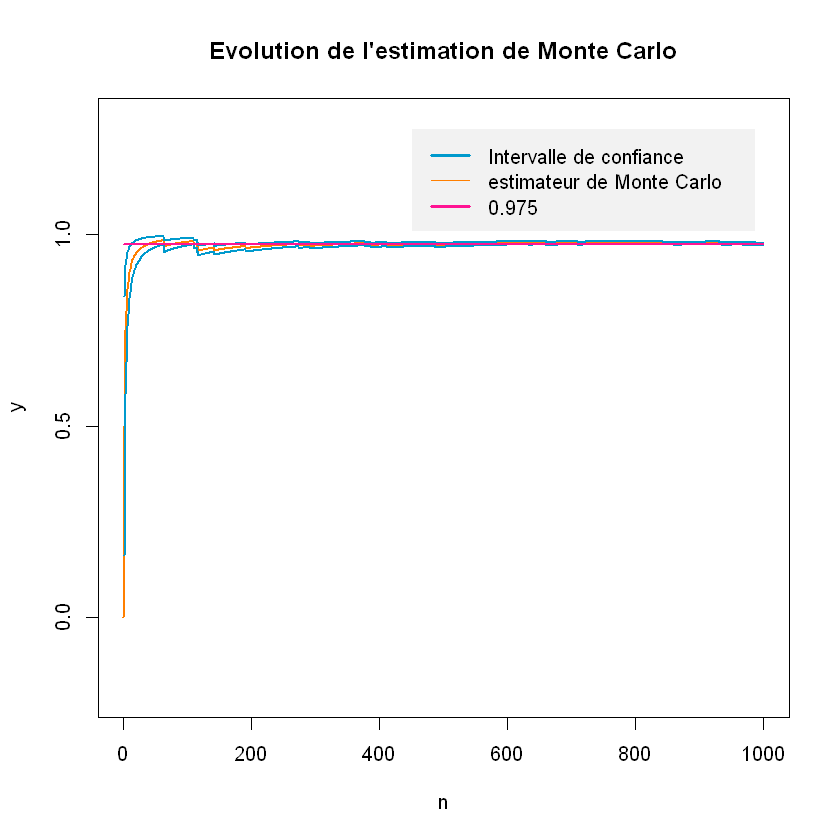

In [17]:
set.seed(25) ## Pour pouvoir reproduire les résultats 
tester_quantil_empirique(79,79,1000,1000,0.975)  


## 3 - b)

In [18]:
## fonction pour obtenir la statistique de Wilcoxon-Mann-Whitney
get_stat_Wilcoxon_MW<-function(x,y){
    n1=length(x)
    n2=length(y)
    mu=(n1*(n1+n2+1))/2
    sigma=mu*(n2/6)
    return ((get_Ranked_R1(x,y)-mu)/sqrt(sigma))
}

In [19]:
## fonction pour obtenir la statistique du Khi 2 d'homogénéité
get_stat_Chi2_homogene<-function(x,y,J){
    stat<-c()
    for (i in 0:(J-1)){
        N1=sum((qnorm(i/J)<=x)*(x<qnorm(((i+1)/J))))
        N2=sum((qnorm(i/J)<=y)*(y<qnorm(((i+1)/J))))
        stat<-c(stat,((N1-N2)^2)/N2)
    }
    return(sum(stat))
}

In [20]:
## On créé les échantillons WMWi et S_chi_i
## Sous H_1 les échantillons suivent des lois différentes
J=5
chi2_vect<-c()
WMW_vect<-c()
for (i in 1:1000){
    
#Sous H_1
    Z1<-rnorm(79,0.25,1)
    Z2<-rnorm(79,-0.25,1)
    
    chi2_vect<-c(chi2_vect,get_stat_Chi2_homogene(Z1,Z2,J)) 
    WMW_vect<-c(WMW_vect,get_stat_Wilcoxon_MW(Z1,Z2))
    
}

In [21]:
alpha<-0.05
WMW_vect_puiss<-1-(qnorm(alpha/2)<=WMW_vect)*(WMW_vect<qnorm(1-alpha/2))

chi2_vect_puiss<-chi2_vect>qchisq(1-alpha,J-1)

### Puissance du test de WMW

,valeur_estimateur_MC,var,born_inf_IC,born_sup_IC
1000,0.852,0.1262222,0.8444222,0.8595778


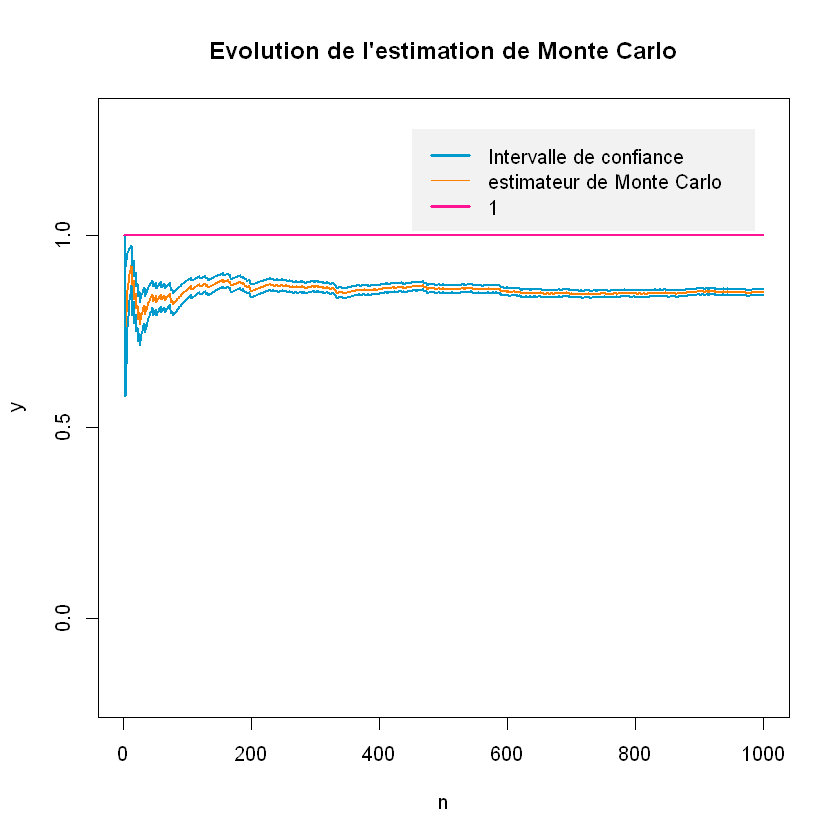

In [22]:
MC(WMW_vect_puiss,0.5,1)

### Puissance du test chi 2 d'homogénéité

,valeur_estimateur_MC,var,born_inf_IC,born_sup_IC
1000,0.923,0.07114214,0.917311,0.928689


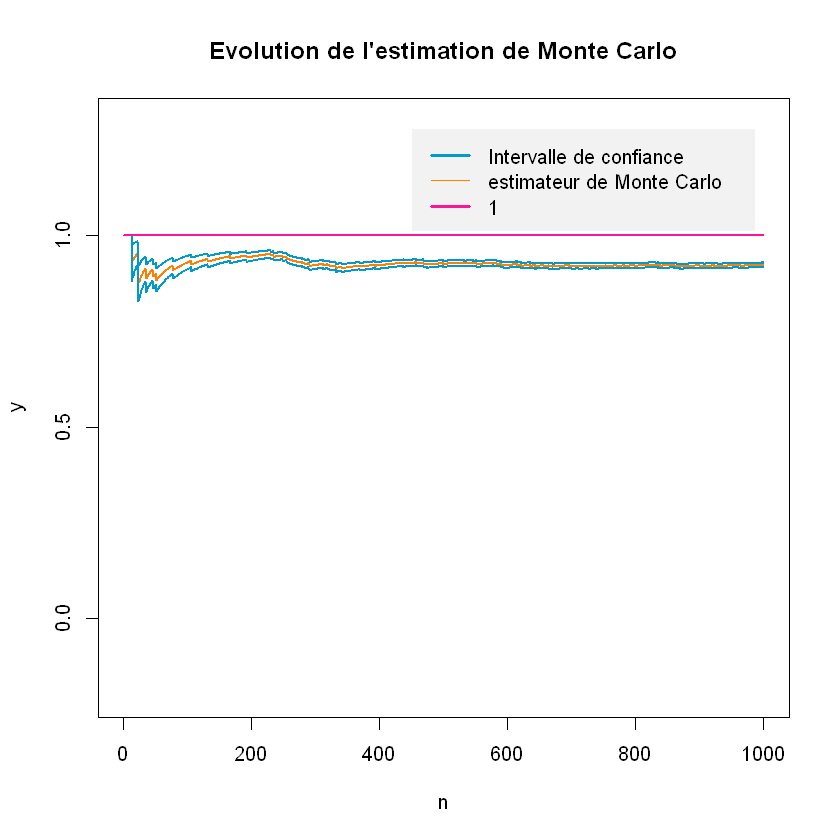

In [23]:
MC(chi2_vect_puiss,0.5,1)

### Nota Bene (ça ne marche pas ...)

La statistique du $\chi^2$ d'adéquation n'est malheureusement pas une $\chi^2$ a J-1 degrés de liberté comme on l'a pourtant dit ...

La moyenne empirique ne converge pas vers la moyenne théorique sous $H_0$ (J-1)

In [24]:
J=3
chi2_vect<-c()
for (i in 1:1000){
## Sous H_0
    Z1<-rnorm(79,0,1)
    Z2<-rnorm(79,0,1)
     
    chi2_vect<-c(chi2_vect,get_stat_Chi2_homogene(Z1,Z2,J))
    
}

,valeur_estimateur_MC,var,born_inf_IC,born_sup_IC
1000,4.557144,23.95841,4.452743,4.661545


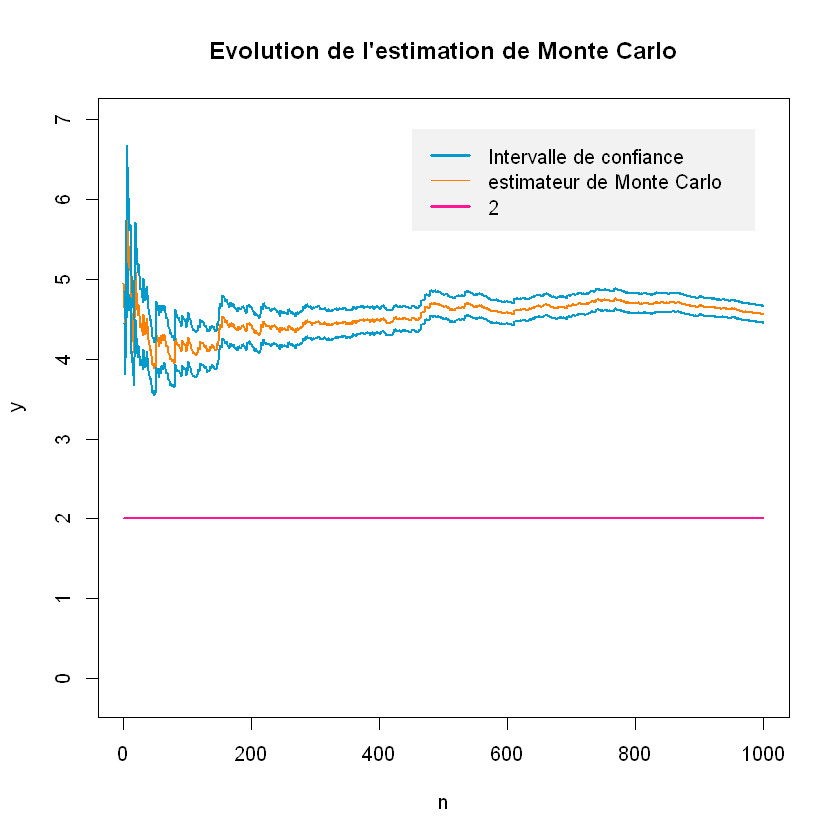

In [25]:
MC(chi2_vect,0.5,2)

Test du $\chi^2$ pour l'adéquation avec une loi normale 

In [26]:
## fonction pour obtenir la statistique du Khi 2 d'adéquation
get_stat_Chi2_adequation<-function(x,J,mu,sigma){
    m<-length(x)
    stat<-c()
    for (i in 0:(J-1)){
        N1=sum((qnorm(i/J,mu,sigma)<=x)*(x<qnorm(((i+1)/J),mu,sigma)))
        stat<-c(stat,((N1-m/J)^2)/(m/J))
    }
    return(sum(stat))
}

In [27]:
J=5
chi2_vect<-c()
for (i in 1:1000){
## Sous H_0
    Z1<-rnorm(79,0,1)
    Z2<-rnorm(79,0,1)
     
    chi2_vect<-c(chi2_vect,get_stat_Chi2_adequation(c(Z1,Z2),J,0,1))
    
}

Sous $H_0$ il semblerait qu'on a bien une $\chi^2$ a J-1 degrés de liberté

,valeur_estimateur_MC,var,born_inf_IC,born_sup_IC
1000,3.924051,7.031411,3.867492,3.980609


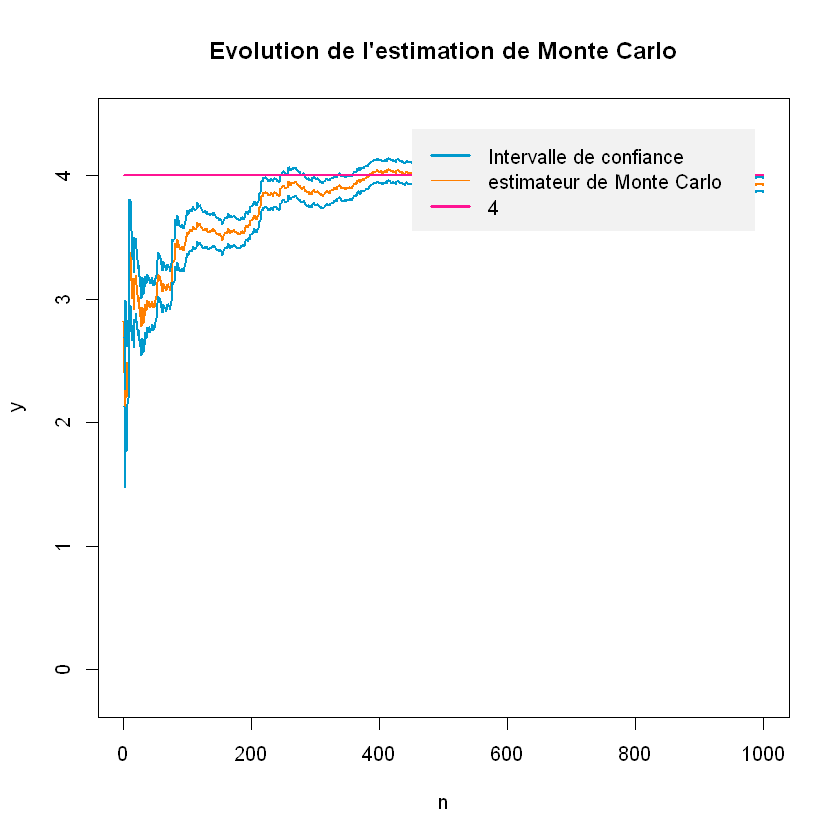

In [28]:
MC(chi2_vect,0.5,4)

### Puissance du test chi 2 d'adéquation

On test aussi la puissance du test d'adéquation 

In [29]:
J=5
chi2_vect<-c()
for (i in 1:1000){
## Sous H_0
    Z1<-rnorm(79,0.5,1)
    Z2<-rnorm(79,0.25,1)
     
    chi2_vect<-c(chi2_vect,get_stat_Chi2_adequation(c(Z1,Z2),J,0,1))
    
}

In [30]:
alpha<-0.05

chi2_vect_puiss<-chi2_vect>qchisq(1-alpha,J-1)

,valeur_estimateur_MC,var,born_inf_IC,born_sup_IC
1000,0.947,0.05024124,0.9422191,0.9517809


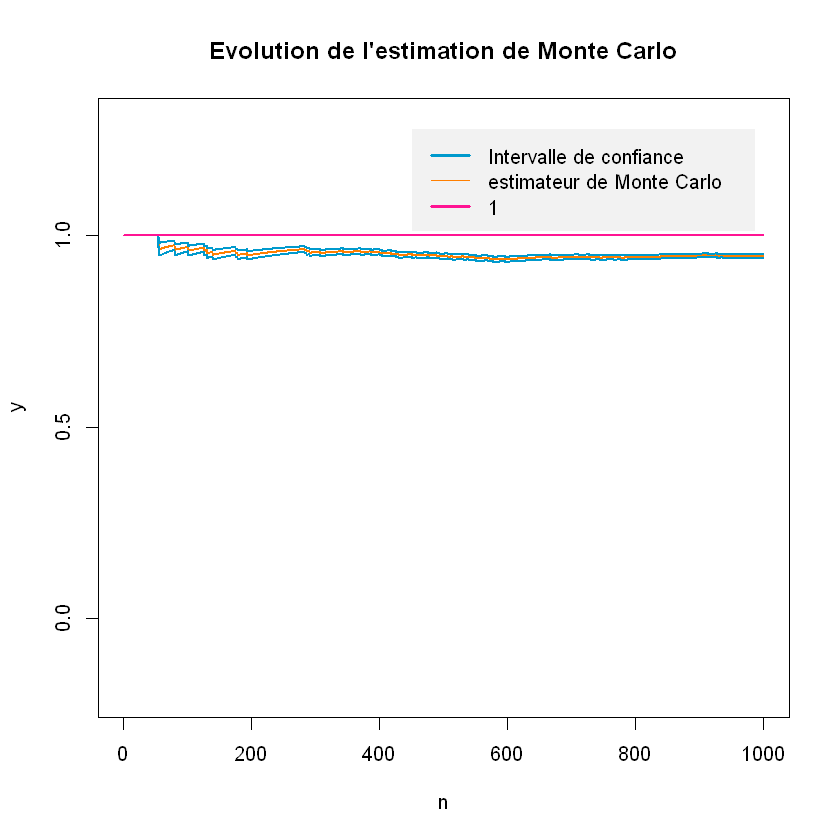

In [31]:
MC(chi2_vect_puiss,0.5,1)

## 4 - Approche naïve des tests multiples 

## 5 - Contrôle de la "Family-Wise Error Rate"

## 6 - Procédure de Benjamini-Hochberg 

In [32]:
Benjami_Hoch<-function(vect_p,alpha){
## En input on met la liste des p-valeur (p1,p2,...,pm) non ordonnées
    ## cad : pi est la p valuer de la ième hypothèse
## Renvoie les numéros des hypothèses qu'on rejette
    m=length(vect_p)
    df<-data.frame(p_valeurs=vect_p,hypothese_num=c(1:m))
    or<-df[order(df$p_valeurs),]
    or$rank<-1:m
    or$BH<-(alpha*or$rank)/m
    k<-max((or$p_valeurs < or$BH )*(or$rank))
    
    if (k==0){
        print("On ne rejette aucune hypothèse")
    }
    else{
        return(or$hypothese_num[1:k][order(or$hypothese_num[1:k])])}
}

In [33]:
p_val_sous_H0<-runif(100)

In [34]:
Benjami_Hoch(p_val_sous_H0,0.75)

[1] "On ne rejette aucune hypothèse"
